In [1]:
import os.path
import numpy as np
import pandas as pd
import torch
import pickle
import subprocess
from matplotlib import pyplot as plt
from Bio import SeqIO
from importlib import reload
import warnings

from scipy.stats import mode
from sklearn.neighbors import KernelDensity
from skimage.graph import route_through_array
from scipy.spatial import cKDTree

import matplotlib.cm as cm

import minimal_version.parser_handler
%cd /Users/dahala/GitHub/TRPase-VAE-Mining/vae_notebooks/
from minimal_version.preprocess_msa import Preprocessor, weight_sequences
from minimal_version.msa import MSA
from minimal_version.utils import Capturing, store_to_pkl, store_to_fasta, load_from_pkl

from minimal_version.train import setup_train, Train

%cd /Users/dahala/GitHub/TRPase-VAE-Mining
from custom_functions import *
%cd /Users/dahala/GitHub/TRPase-VAE-Mining/vae_notebooks/notebooks/



/Users/dahala/GitHub/TRPase-VAE-Mining/vae_notebooks
/Users/dahala/GitHub/TRPase-VAE-Mining
/Users/dahala/GitHub/TRPase-VAE-Mining/vae_notebooks/notebooks


## VAE Visualization

In [2]:
CONFIGURATION_FILE = "msaEnzymeMiner_TRPase_trim_400_600.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
run_HMM = False # Set to True if you want to build HMM from MSA
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = False

Configuration file stored in ../results/EnzymeMiner_TRPase_trim_400_600/config/2025-09-19_16-50.json
 Working with msaEnzymeMiner_TRPase_trim_400_600.json configuration file!


In [3]:
if run_HMM:
    HMMbuild = HMMmodule(run)
    HMMbuild.MSA_create() # Create MSA from sequences
    HMMbuild.build() # Build HMM from MSA
    HMMbuild.align('EnzymeMiner_TRPase_trim_400_600',fasta_ext='fasta') # Align sequences to HMM


In [4]:
"""
Preprocess MSA and prepare it for VAE model training
"""

# logging
msa_log = open(os.path.join(run.logs, 'msa_log.txt'), "w")

# MSA loading
if PFAM_INPUT:
    msa = MSA.load_pfam(run.dataset)
else:
    msa = MSA.load_msa(run.dataset)
MSA.amino_acid_dict(run.pickles)
msg = f"MSA in {run.dataset} loaded\n" \
      f"number of sequences: {len(list(msa.keys()))}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')

# MSA preprocessing
preprocessor = Preprocessor(run)
with Capturing() as output:
    msa, msa_keys = preprocessor.trim_msa(msa)
msa_log.write(" MSA Preprocessing \n" + "\n".join(output) + f'\n{"="*80}\n')
assert (msa.shape[0] == len(msa_keys))
trim_file_path = os.path.join(run.msa, "trimmed_msa.fasta")
msg = f"Trimmed MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Trimmed MSA is stored at {trim_file_path}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')
msa_num_dict_shuffled = {k: seq for k, seq in zip(msa_keys, msa)}  # transform to dictionary, have keys together
# but secure that query and fixed sequences are at the beginning 
msa_num_dict = {k: msa_num_dict_shuffled[k] for k in preprocessor.keep_keys}
msa_num_dict.update({k: msa_num_dict_shuffled[k] for k in msa_num_dict_shuffled if k not in preprocessor.keep_keys})

trimmed_msa = MSA.number_to_amino(msa_num_dict)
store_to_fasta(trimmed_msa, trim_file_path)
store_to_pkl({run.query: trimmed_msa[run.query]}, os.path.join(run.pickles, "reference_seq.pkl"))

# Filtering or weighting
with Capturing() as output:
    if run.clustering:  # MSA filtering
        print(f"MSA {run.identity}% identity filtering step")
        msa_num_dict = preprocessor.identity_filtering(msa_num_dict)
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = np.ones(msa.shape[0])  # we just provide uniform weights for all sequences
    else:  # otherwise the weighting mechanism will be applied
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = weight_sequences(msa)
msa_log.write("\n".join(output))
train_msa_file_path = os.path.join(run.msa, "training_msa.fasta")
training_alg = MSA.number_to_amino(training_alg)
store_to_fasta(training_alg, train_msa_file_path)
msg = f"Training MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Training MSA is stored at {train_msa_file_path}"
print(msg)
msa_log.write(msg + f'\n{"=" * 80}\n')

store_to_pkl(seq_weight, os.path.join(run.pickles, "seq_weight.pkl"))
store_to_pkl(training_alg, os.path.join(run.pickles, "training_alignment.pkl"))

# MSA one-hot encoding
binary = MSA.number_to_binary(msa)
store_to_pkl(binary, os.path.join(run.pickles, "seq_msa_binary.pkl"))
msa_log.close()

MSA in ../datasets/EnzymeMiner_TRPase_trim_400_600_fix.afa loaded
number of sequences: 5852
Trimmed MSA has 5852 sequences and the width is 455
Trimmed MSA is stored at ../results/EnzymeMiner_TRPase_trim_400_600/msa/trimmed_msa.fasta
Training MSA has 5852 sequences and the width is 455
Training MSA is stored at ../results/EnzymeMiner_TRPase_trim_400_600/msa/training_msa.fasta


In [5]:
with open(run.pickles+ "/msa_columns.pkl", "rb") as input_file:
   msa_columns = pickle.load(input_file)

In [6]:

load_from_pkl(os.path.join(run.model, "model_params.pkl"))['model']

'vae'

In [7]:
exp_res = pd.read_csv('../../extra_data/Cleaned_Experimental_Data.csv',index_col=0).iloc[:-5,:]
rel_act = pd.read_excel('../../extra_data/20250328_TRPase_rel_act.xlsx', sheet_name='Sheet2',index_col=1)
rel_act = rel_act.loc[exp_res.index]

In [8]:
panel = pd.read_csv('../../extra_data/enzyme_panel.csv', sep='\t')
name_converter = pd.read_csv('../../extra_data/TRPase_name_converter.csv',index_col=0)
panel['ID_VAE'] = panel['Abbreviation'].apply(lambda x: name_converter.loc[x,'Uniprot_ID'])

In [10]:
msa = MSA.load_msa(run.dataset)
full_seqs = SeqIO.to_dict(SeqIO.parse('../../extra_data/Trim_400_600.fasta', 'fasta'))

In [11]:
if os.path.exists(run.result+'/full_embedding.csv'):
    df_emb = pd.read_csv(run.result+'/full_embedding.csv', sep='\t')
else:
    print("Calculating embeddings...")

In [12]:
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
from tqdm import tqdm
import sys
import os

if os.path.exists(run.result+'/full_embedding.csv'):
    df_emb = pd.read_csv(run.result+'/full_embedding.csv', sep='\t')

else:
    ESMC_model = 'esmc_600m' # Choose from 'esmc_300m', 'esmc_600m'
    pooling = 'mean'  # Choose from 'max', 'min', or 'mean'

    # Load the ESMC model
    client = ESMC.from_pretrained(ESMC_model).to("cpu")  # or "cuda"

    # Initialize an empty list to store the results
    results = []
    # Loop through the protein sequences
    for prot in tqdm(full_seqs.keys()):#arch_POI+euka_POI+bact_POI:
        record = full_seqs[prot]
        sequence = str(record.seq)  # Get the protein sequence
        protein = ESMProtein(sequence=sequence)  # Create an ESMProtein object

        # Encode the protein sequence
        protein_tensor = client.encode(protein)

        # Get the logits and embeddings
        logits_output = client.logits(
            protein_tensor, LogitsConfig(sequence=True, return_embeddings=True)
        )

        # Extract embeddings for the last layer (last element in the embeddings tensor)
        last_layer_embeddings = logits_output.embeddings[-1]  # Shape: (sequence_length, hidden_size)

        # Apply the chosen pooling method
        if pooling == 'mean':
            pooled_embedding = last_layer_embeddings.mean(dim=0).cpu().numpy()  # Mean pooling across sequence length
        elif pooling == 'min':
            pooled_embedding = last_layer_embeddings.min(dim=0)[0].cpu().numpy()  # Min pooling across sequence length
        elif pooling == 'max':
            pooled_embedding = last_layer_embeddings.max(dim=0)[0].cpu().numpy()  # Max pooling across sequence length
        else:
            print(f"Error: Unsupported pooling method '{pooling}'")
            sys.exit(1)

        # Initialize the row dictionary with the enzyme name (protein ID)
        row = {'enzyme': record.id}

        # Store the pooled embedding values as individual columns with numerical keys (0, 1, 2, ...)
        for dim in range(pooled_embedding.shape[0]):
            row[str(dim)] = float(pooled_embedding[dim])  # Ensure it is stored as a numeric value

        # Append the row to results
        results.append(row)

    # Convert the results list to a DataFrame
    df_emb = pd.DataFrame(results)

    # Ensure columns are in the correct order: 'enzyme' first, then the pooled embeddings
    cols = ['enzyme'] + [str(i) for i in range(pooled_embedding.shape[0])]
    df_emb = df_emb[cols]

    # Save the DataFrame to a CSV file with tab-separated values
    df_emb.to_csv(run.result+'/full_embedding.csv', index=False, sep='\t')  # Write the results to the output file

X_emb = df_emb.drop(columns=["enzyme"]).to_numpy()  # shape (20, 1152)

from sklearn.preprocessing import normalize

# X: numpy array of shape (N, d), from your df_emb.drop(columns=["enzyme"])
X_norm = normalize(X_emb)  # row-wise L2 normalization

/Users/dahala/anaconda3/envs/vae_env2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Explained variance: [0.02707248 0.01420319 0.00379436 0.0027241  0.00157858 0.00151681
 0.00106601 0.00074319 0.00065657 0.00050474]
Explained variance ratio: [0.456372   0.23942899 0.06396313 0.04592131 0.02661076 0.02556942
 0.0179702  0.01252831 0.01106809 0.00850864]


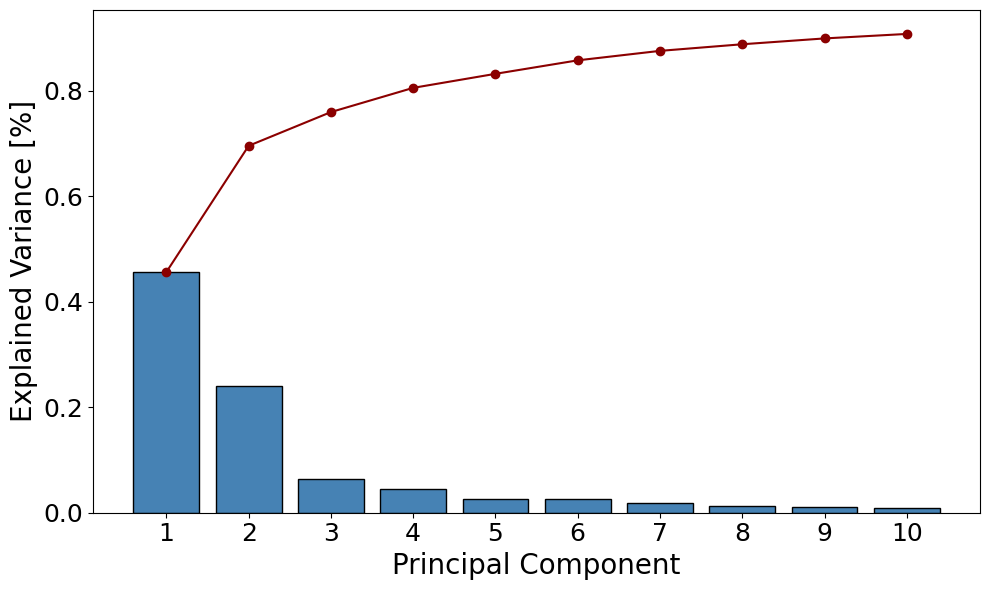

In [13]:
from sklearn.decomposition import PCA

# X_emb: your embeddings matrix, shape (N, d)
pca = PCA(n_components=10, random_state=0)
pca.fit(X_emb)

# Explained variance (absolute) and ratio
explained_var = pca.explained_variance_
explained_ratio = pca.explained_variance_ratio_

print("Explained variance:", explained_var)
print("Explained variance ratio:", explained_ratio)

# Plot variance ratio for SI figure
plt.figure(figsize=(10,6))
plt.bar(range(1, 11), explained_ratio, color="steelblue",edgecolor="black")
plt.plot(range(1, 11), np.cumsum(explained_ratio), marker="o", color="darkred")
plt.xlabel("Principal Component", fontsize=20)
plt.ylabel("Explained Variance [%]", fontsize=20)
plt.xticks(range(1, 11))
#plt.legend()
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.show()

In [14]:
# Center and reduce embeddings to 1D with PCA
pca = PCA(n_components=1, random_state=0)
coords_1d_pca = pca.fit_transform(X_emb).ravel()  # shape (N,)
# Normalize to [0,1] for color mapping
normed = (coords_1d_pca - coords_1d_pca.min()) / (np.ptp(coords_1d_pca) + 1e-9)
cmap = plt.cm.bone_r  # any single-hue colormap
colors = cmap(normed)

In [15]:
domain_color = {'Archaea':"#00EAFF",'Bacteria':"#FEBE10",'Eukaryota':'#FF0000'}
domain_color2 = {'Archaea':'#aec7e8','Bacteria':'#ffbb78','Eukaryota':'#98df8a'}

/Users/dahala/GitHub/TRPase-VAE-Mining
/Users/dahala/GitHub/TRPase-VAE-Mining/vae_notebooks/notebooks


/Users/dahala/GitHub/TRPase-VAE-Mining/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.lo

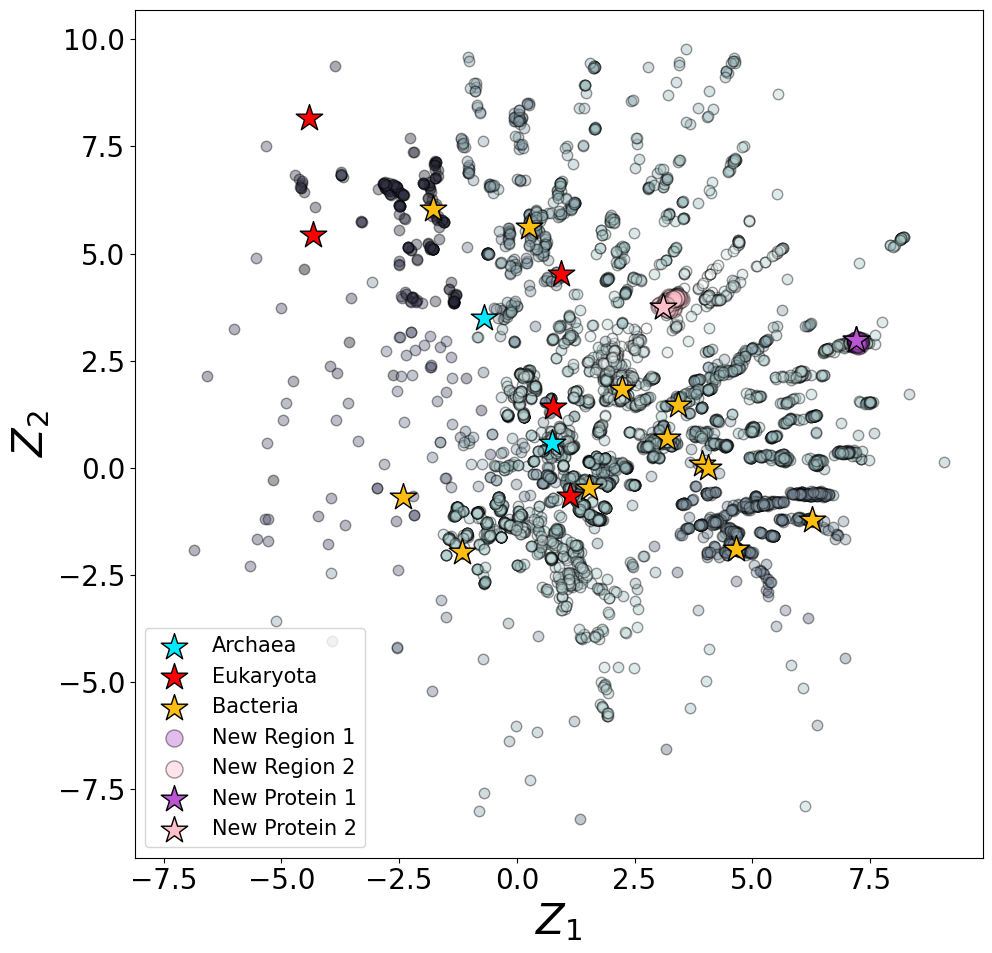

In [16]:
%cd /Users/dahala/GitHub/TRPase-VAE-Mining
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/TRPase-VAE-Mining/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


#query_coords = latent_space.key_to_embedding(run.fixed_sequences)
new1_coords = latent_space.key_to_embedding(['WP_139427101.1'])
new2_coords = latent_space.key_to_embedding(['TMB50071.1'])

panel_coords = latent_space.key_to_embedding(panel['ID_VAE'].to_list())

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))
#'#FEBE10'
for i in range(len(msa_embeddings)):
    ax.plot(msa_embeddings[i, 0], msa_embeddings[i, 1], '.', alpha=0.4, markersize=15, color=colors[i],zorder=0,markeredgecolor='black')

for i in panel['Domain'].unique():
    subset = panel[panel['Domain'] == i]
    ax.scatter(panel_coords[0::2][subset.index], panel_coords[1::2][subset.index], color=domain_color[i],edgecolor='black',s=400,alpha=1,zorder=1,label=i,marker='*')
# ax.scatter(arch_coords[0::2], arch_coords[1::2], color="#0099FF",edgecolor='black',s=300,alpha=1,label='Archaea',zorder=1,marker='*')
# ax.scatter(euka_coords[0::2], euka_coords[1::2], color='red',edgecolor='black',s=300,alpha=1,label='Eukaryota',zorder=1,marker='*')
# ax.scatter(bact_coords[0::2], bact_coords[1::2], color="#FEBE10",edgecolor='black',s=300,alpha=1,label='Bacteria',zorder=1,marker='*')
#64D72F
#7EF148
mask_x = (msa_embeddings[:, 0]<7.3) & (msa_embeddings[:, 0]>7.2)
mask_y = (msa_embeddings[:, 1]<3) & (msa_embeddings[:, 1]>2.5)

mask = mask_x & mask_y
msa_embeddings_new_reg_1 = msa_embeddings[mask]

ax.scatter(msa_embeddings_new_reg_1[:, 0], msa_embeddings_new_reg_1[:, 1], color='#BA55D3',edgecolor='black',s=150,alpha=0.4,zorder=1,label='New Region 1')


mask_x = (msa_embeddings[:, 0]<3.5) & (msa_embeddings[:, 0]>3)
mask_y = (msa_embeddings[:, 1]<4) & (msa_embeddings[:, 1]>3.6)

mask = mask_x & mask_y
msa_embeddings_new_reg_2 = msa_embeddings[mask]

ax.scatter(msa_embeddings_new_reg_2[:, 0], msa_embeddings_new_reg_2[:, 1], color='pink',edgecolor='black',s=150,alpha=0.4,zorder=1,label='New Region 2')

ax.scatter(new1_coords[0::2], new1_coords[1::2], color='#BA55D3',edgecolor='black',s=400,alpha=1,label='New Protein 1',zorder=2,marker='*')
ax.scatter(new2_coords[0::2], new2_coords[1::2], color='pink',edgecolor='black',s=400,alpha=1,label='New Protein 2',zorder=2,marker='*')

# Project 
ax.legend(loc='lower left', fontsize=15)
ax.tick_params(labelsize=20)
ax.set_xlabel(r'$Z_1$', fontsize=30)
ax.set_ylabel(r'$Z_2$', fontsize=30)
ax.set_box_aspect(1)
#ax.set_title('Domains of TRPase proteins',fontsize=30)

plt.tight_layout()
#fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")

In [17]:
with open(run.result+ "/new_region_1_fasta", "w") as output_handle:
    for inbtw in msa_embeddings_new_reg_1:
        for i, emb in enumerate(msa_embeddings):
            if torch.equal(torch.tensor(emb), torch.tensor(inbtw)):
                SeqIO.write(full_seqs[msa_keys[i]], output_handle, "fasta")

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_25425/1890141081.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if torch.equal(torch.tensor(emb), torch.tensor(inbtw)):


In [18]:
with open(run.result+ "/new_region_2_fasta", "w") as output_handle:
    for inbtw in msa_embeddings_new_reg_2:
        for i, emb in enumerate(msa_embeddings):
            if torch.equal(torch.tensor(emb), torch.tensor(inbtw)):
                SeqIO.write(full_seqs[msa_keys[i]], output_handle, "fasta")

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_25425/3982890919.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if torch.equal(torch.tensor(emb), torch.tensor(inbtw)):


## VAE Training Benchmarking

In [19]:
benchmark_path = run.result + '/benchmark/marginals_benchmark.csv'
benchmark_pd = pd.read_csv(benchmark_path,index_col=0)

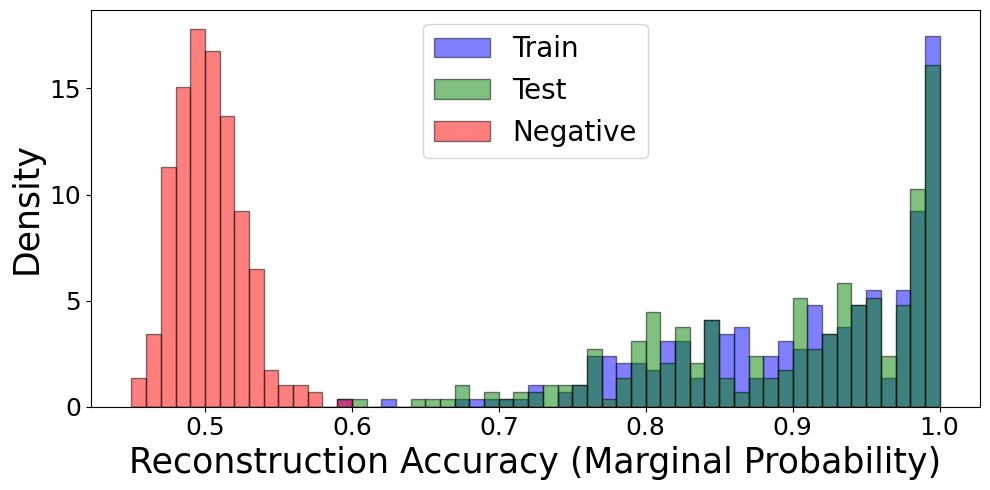

In [20]:
#Plotting the benchmark results

fig_bench, ax = plt.subplots(1, 1,figsize=(10,5))
ax.hist(benchmark_pd['Train'],bins=55,range=(0.45,1),alpha=0.5,color='blue',edgecolor='black',label='Train',density=True)
ax.hist(benchmark_pd['Positive'],bins=55,range=(0.45,1),alpha=0.5,color='green',edgecolor='black',label='Test',density=True)
ax.hist(benchmark_pd['Negative'],bins=55,range=(0.45,1),alpha=0.5,color='red',edgecolor='black',label='Negative',density=True)

ax.set_xlabel('Reconstruction Accuracy (Marginal Probability)', fontsize=25)
ax.set_ylabel('Density', fontsize=25)
ax.legend(loc='upper center', fontsize=20)
ax.tick_params(labelsize=18)
#ax.set_title('Benchmark results',fontsize=30)
plt.tight_layout()
fig_bench.savefig(os.path.join(run.results, f"benchmark.png"))

plt.show()


In [21]:
benchmark_path = '../results/EnzymeMiner_TRPase_trim_400_600/logs/train_log.txt'
benchmark_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=8,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_pd[3] = benchmark_pd[3].str.replace(',','').astype(float)

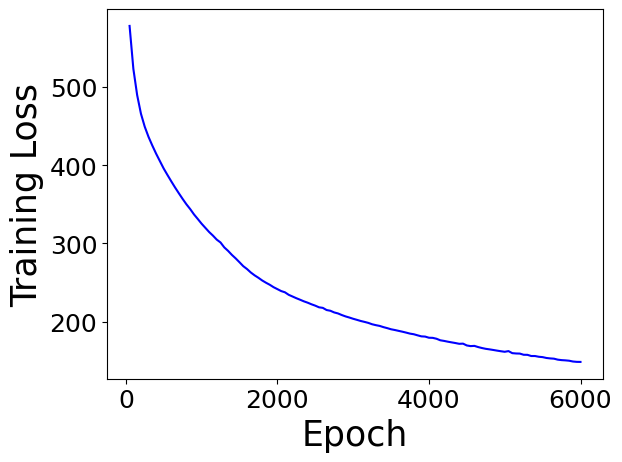

In [22]:
plt.plot(benchmark_pd[3],benchmark_pd[5],color='blue')
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Training Loss',fontsize=25)
#plt.legend(loc='upper right', fontsize=20)
plt.tick_params(labelsize=18)


## Experimental Data

In [24]:
exp_data = pd.read_csv('../../extra_data/Table 1.csv',index_col=0)

In [25]:
kin_data = pd.read_csv('../../extra_data/kin_data_commasep.csv',index_col=0)
kin_data['Conditions'] = ['Standard','Assay','Optimal']*6
cond_shape_dict = {'Standard':'o','Assay':'s','Optimal':'*'}
size_dict = {'Standard':200,'Assay':200,'Optimal':400}
kin_prot_color_dict = {'TtiTIL':'#1f77b4',
                       'AsoTIL':'#ff7f0e',
                       'PvuTIL':'#2ca02c',
                       'PreTIL':'#d62728',
                       'EcoTIL':'#9467bd',
                       'VchTIL':'#8c564b',

}
import matplotlib.colors as mcolors
# Normalize to the temperature range
norm = mcolors.Normalize(vmin=exp_data['T'][kin_data.index.unique()].min(), vmax=exp_data['T'][kin_data.index.unique()].max())
cmap = plt.colormaps.get_cmap("coolwarm")  # blue → red
# Create dictionary of colors
kin_prot_color_dict = {prot: cmap(norm(temp)) for prot, temp in exp_data['T'][kin_data.index.unique()].items()}

# Topt values for the 6 enzymes
prot_Topt = {
    'TtiTIL': 45,
    'AsoTIL': 65,
    'PvuTIL': 50,
    'PreTIL': 50,
    'EcoTIL': 45,
    'VchTIL': 40
}

# sort proteins by Topt
sorted_prots = sorted(prot_Topt.items(), key=lambda x: x[1])

# get 6 discrete colors from blue→red
cmap = cm.get_cmap("coolwarm", 6)  # 6 evenly spaced colors
colors = [cmap(i) for i in range(6)]
# map proteins to colors in Topt order
kin_prot_color_dict = {
    prot: colors[i] for i, (prot, _) in enumerate(sorted_prots)
}

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_25425/3411159383.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm", 6)  # 6 evenly spaced colors


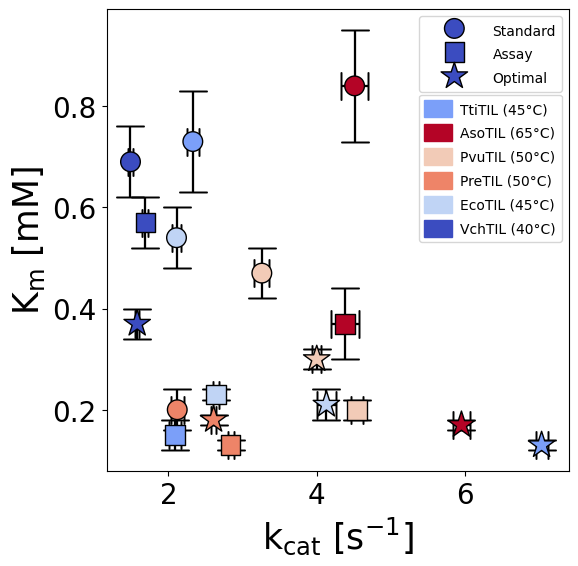

In [47]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(1, 1,figsize=(6,6))

for cond in kin_data['Conditions'].unique():
    subset = kin_data[kin_data['Conditions']==cond]
    plt.scatter(subset['kcat'], subset['KM'], edgecolor='black', alpha=1,label=cond,zorder=1,s=size_dict[cond],marker=cond_shape_dict[cond],
            color=list(kin_prot_color_dict.values()))

    plt.errorbar(kin_data['kcat'], kin_data['KM'],xerr=kin_data['kcat_std'], yerr=kin_data['KM_std'],
                fmt='o', alpha=1, zorder=0,capsize=10,markersize=0,ecolor='k',
                markeredgecolor='black',color='black')
plt.ylabel('K$_\mathrm{m}$ [mM]',fontsize=25)
plt.xlabel('k$_\mathrm{cat}$ [s$^{-1}$]',fontsize=25)


# --- First legend (marker shapes) ---
shape_legend = ax.legend(
    title=None,
    loc="upper right",
    bbox_to_anchor=(1, 1),
    fontsize=10,
    handlelength=4.3,
    handleheight=1.5,
    handletextpad=0.6
)
ax.add_artist(shape_legend)

# --- Second legend (protein colors) ---
prot_patches = [
    mpatches.Patch(color=kin_prot_color_dict[prot], label=f"{prot} ({temp}°C)")
    for prot, temp in exp_data['T'][kin_data.index.unique()].items()
]

color_legend = ax.legend(
    handles=prot_patches,
    loc="upper right",
    bbox_to_anchor=(1, 0.83),  # adjust vertical stacking
    fontsize=10,
    handlelength=2,
    handleheight=1.5,
    handletextpad=0.6
)



ax.set_box_aspect(1)
ax.tick_params(labelsize=20)

plt.show()

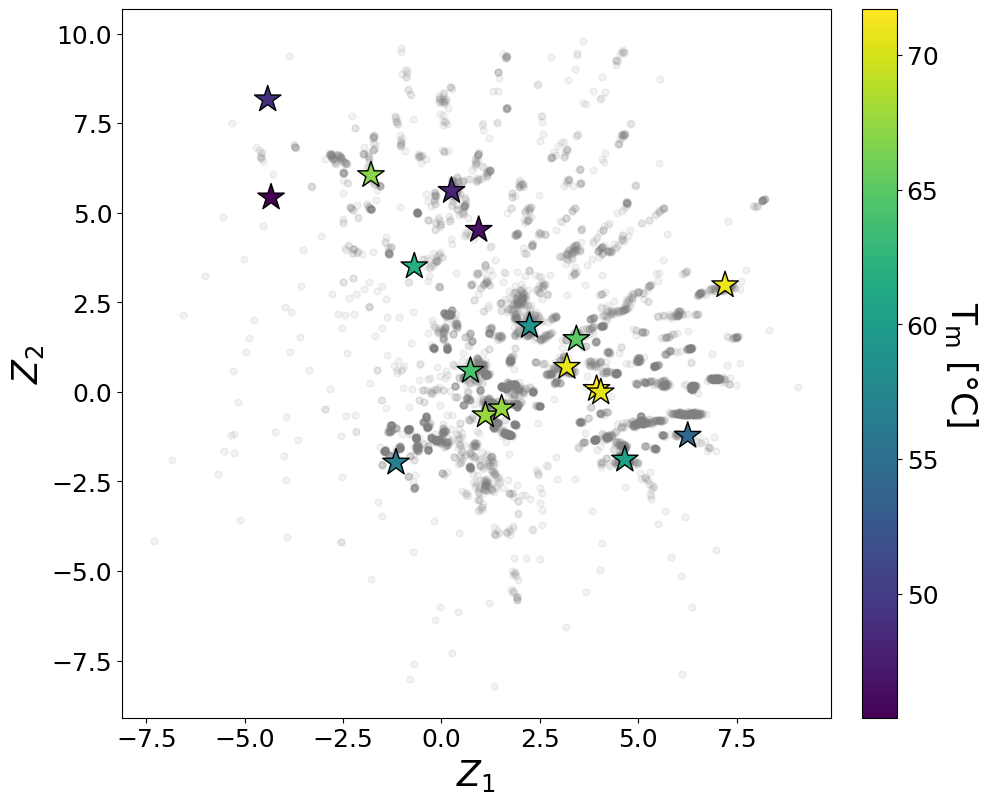

In [29]:
# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(name_converter.loc[exp_data.index].to_numpy())

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=400,c=np.array(exp_data.Tm.to_numpy(),dtype=float),zorder=1,marker='*',cmap='viridis')
cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label(r'T$_\mathrm{m}$ [°C]',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Project 
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
#ax.set_title('Tm values of TRPase proteins',fontsize=30)

#fig_lat.savefig(os.path.join(run.results, f"latent_space_Tm.png"))
    #ax.set_title(f"Latent space projection final")

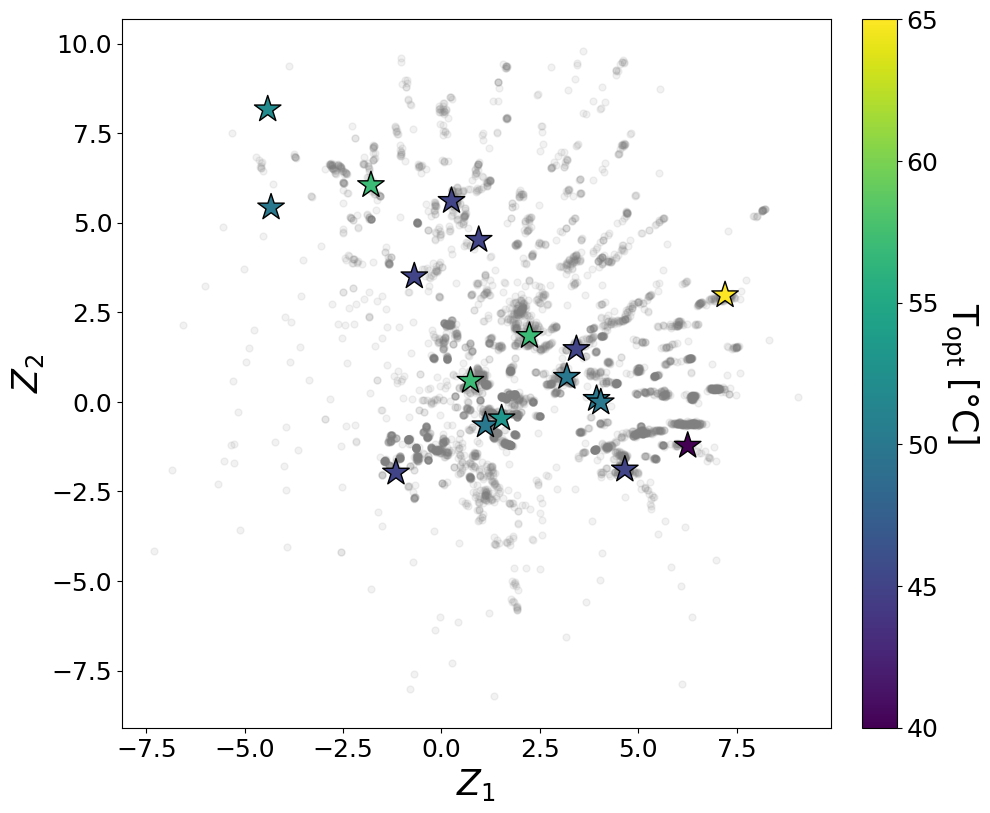

In [28]:
# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(name_converter.loc[exp_data.index].to_numpy())

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=400,c=np.array(exp_data['T'].to_numpy(),dtype=float),zorder=1,marker='*')
cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label(r'T$_\mathrm{opt}$ [°C]',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Project 
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
#ax.set_title('Tm values of TRPase proteins',fontsize=30)

#fig_lat.savefig(os.path.join(run.results, f"latent_space_Tm.png"))
    #ax.set_title(f"Latent space projection final"

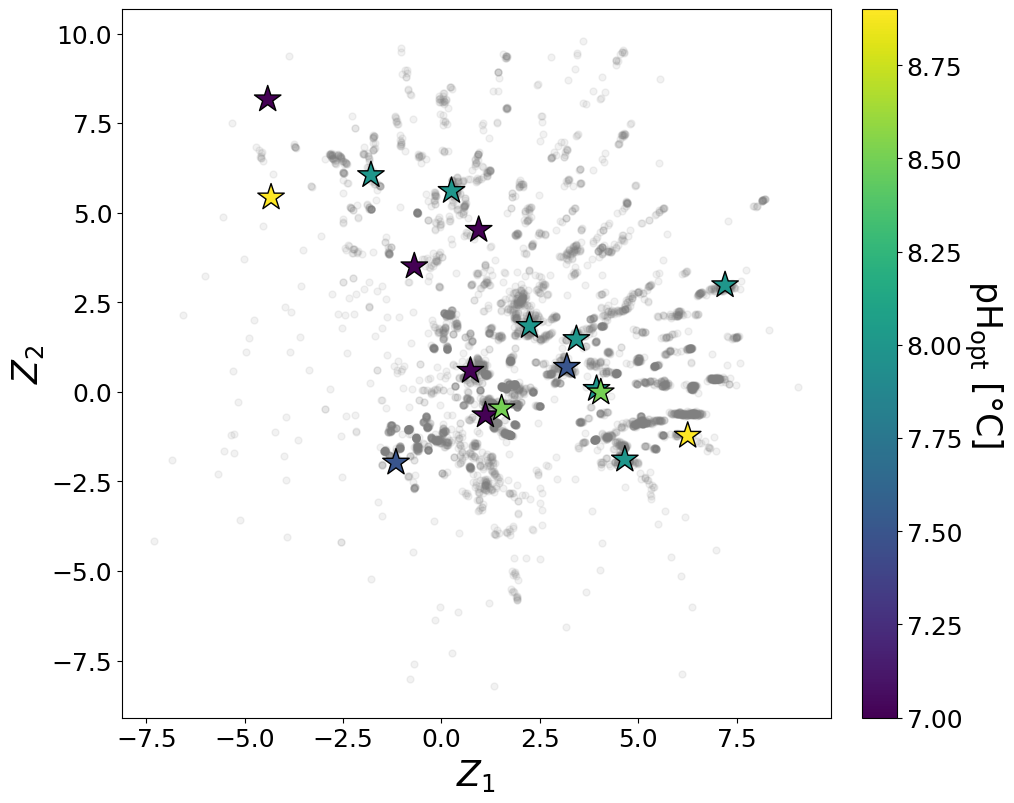

In [30]:
# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(name_converter.loc[exp_data.index].to_numpy())

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=400,c=np.array(exp_data['pH'].to_numpy(),dtype=float),zorder=1,marker='*')
cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label('pH$_\mathrm{opt}$ [°C]',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Project 

ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
#ax.set_title('Tm values of TRPase proteins',fontsize=30)

#fig_lat.savefig(os.path.join(run.results, f"latent_space_Tm.png"))
    #ax.set_title(f"Latent space projection final"

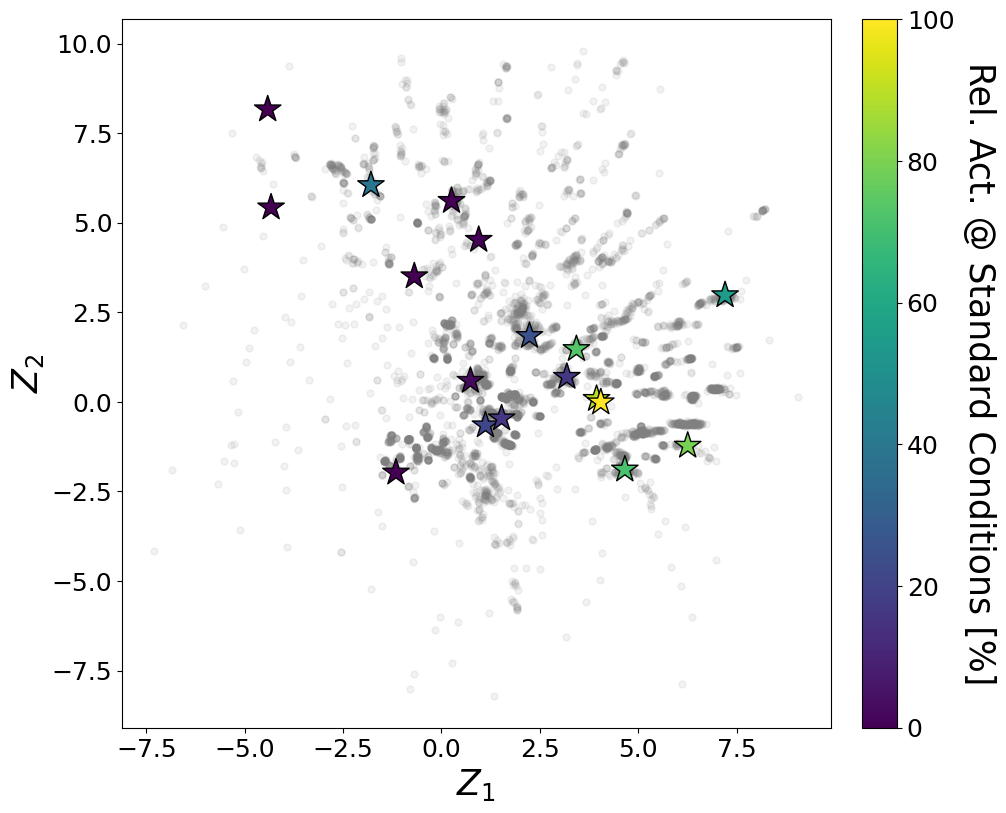

In [31]:
# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(name_converter.loc[exp_data.index].to_numpy())

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=400,c=np.array(exp_data['rel_act_std'].to_numpy(),dtype=float),zorder=1,marker='*')
cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label(r'Rel. Act. @ Standard Conditions [%]',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Project 

ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
#ax.set_title('Tm values of TRPase proteins',fontsize=30)

#fig_lat.savefig(os.path.join(run.results, f"latent_space_Tm.png"))
    #ax.set_title(f"Latent space projection final"

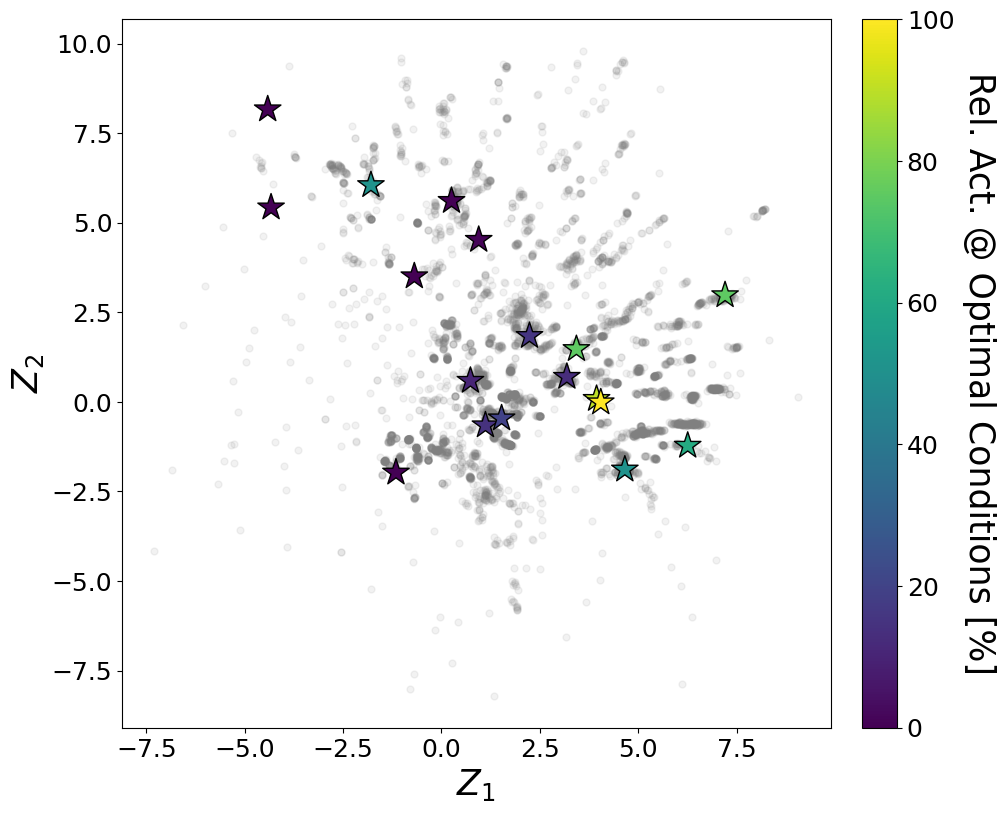

In [32]:
# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]

POI_coords = latent_space.key_to_embedding(name_converter.loc[exp_data.index].to_numpy())

fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)


scatter = ax.scatter(POI_coords[0::2], POI_coords[1::2],edgecolor='black',s=400,c=np.array(exp_data['rel_act_opt'].to_numpy(),dtype=float),zorder=1,marker='*')
cb = fig_lat.colorbar(scatter,ax=ax,fraction=0.04569, pad=0.04)
cb.set_label(r'Rel. Act. @ Optimal Conditions [%]',fontsize=25,rotation=270,labelpad=30)
cb.ax.tick_params(labelsize=18)

# Project 
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)
#ax.set_title('Tm values of TRPase proteins',fontsize=30)

#fig_lat.savefig(os.path.join(run.results, f"latent_space_Tm.png"))
    #ax.set_title(f"Latent space projection final"

## In Silico Examination

In [33]:
seq_selection_netsolp_r1 = pd.read_csv('../../extra_data//TRPases_newreg_1_NetSolP.csv',index_col=0)
seq_selection_netsolp_r1 = seq_selection_netsolp_r1[['fasta','predicted_solubility','predicted_usability']]
seq_selection_soluprot_r1 = pd.read_csv('../../extra_data/TRPase_newreg_1_soluprot.csv',index_col=0)

seq_selection_netsolp_r2 = pd.read_csv('../../extra_data/TRPases_newreg_2_NetSolP.csv',index_col=0)
seq_selection_netsolp_r2 = seq_selection_netsolp_r2[['fasta','predicted_solubility','predicted_usability']]
seq_selection_soluprot_r2 = pd.read_csv('../../extra_data/TRPase_newreg_2_soluprot.csv',index_col=0)

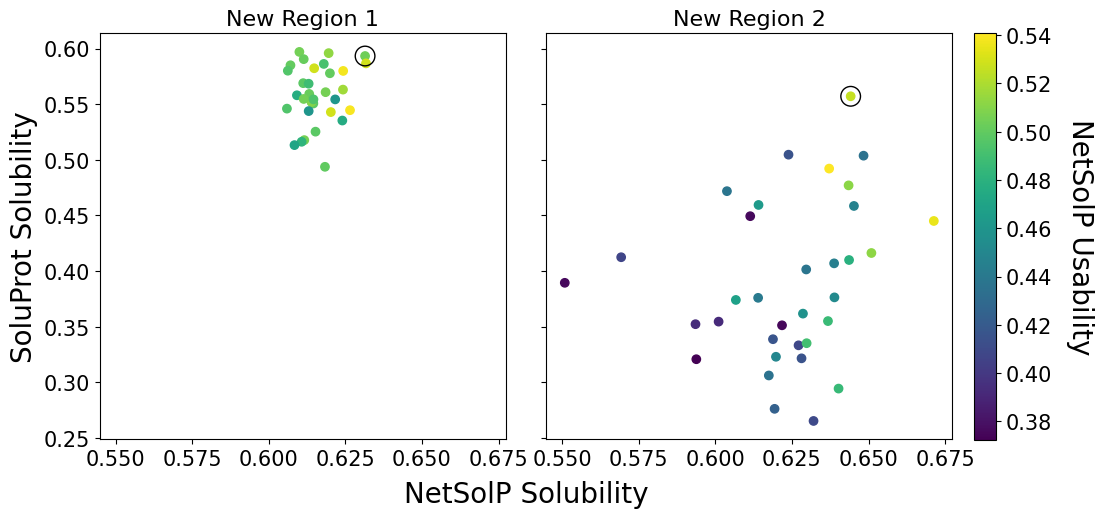

In [34]:

vmin = min(seq_selection_netsolp_r1.predicted_usability.min(), seq_selection_netsolp_r2.predicted_usability.min())
vmax = max(seq_selection_netsolp_r1.predicted_usability.max(), seq_selection_netsolp_r2.predicted_usability.max())

fig, ax = plt.subplots(1, 2,figsize=(11,6),sharex=True,sharey=True)

sc1 = ax[0].scatter(seq_selection_netsolp_r1.predicted_solubility,seq_selection_soluprot_r1.soluble,
              c=seq_selection_netsolp_r1.predicted_usability, vmin=vmin, vmax=vmax, cmap='viridis')
ax[0].scatter(seq_selection_netsolp_r1[seq_selection_netsolp_r1.index=='WP_139427101.1'].predicted_solubility,seq_selection_soluprot_r1[seq_selection_soluprot_r1.fa_id=='WP_139427101.1'].soluble,
              c='none', edgecolor='black', s=200, alpha=1, zorder=3, label='Selected')
ax[0].set_xlabel('NetSolP Solubility',fontsize=20)
ax[0].xaxis.set_label_coords(1.05, -0.1)
ax[0].set_ylabel('SoluProt Solubility',fontsize=20)
ax[0].set_title('New Region 1',fontsize=16)
ax[0].set_box_aspect(1)
ax[1].scatter(seq_selection_netsolp_r2.predicted_solubility,seq_selection_soluprot_r2.soluble,
              c=seq_selection_netsolp_r2.predicted_usability, vmin=vmin, vmax=vmax, cmap='viridis')
ax[1].scatter(seq_selection_netsolp_r2[seq_selection_netsolp_r2.index=='TMB50071.1'].predicted_solubility,seq_selection_soluprot_r2[seq_selection_soluprot_r2.fa_id=='TMB50071.1'].soluble,
              c='none', edgecolor='black', s=200, alpha=1, zorder=3, label='Selected')
#ax[1].set_xlabel('NetSolP Solubility',fontsize=20)
#ax[1].set_ylabel('SoluProt Solubility')
ax[1].set_title('New Region 2',fontsize=16)
ax[1].set_box_aspect(1)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)

cbar_ax = fig.add_axes([0.92, 0.155, 0.02, 0.679])
cbar = fig.colorbar(sc1, cax=cbar_ax)
cbar.set_label('NetSolP Usability', fontsize=20, rotation=270, labelpad=30)
cbar_ax.tick_params(labelsize=15)

fig.subplots_adjust(wspace=0.1)
#plt.tight_layout()
plt.show()

In [35]:
seq_selection_netsolp_r1[(seq_selection_netsolp_r1.predicted_solubility>0.63)]

,fasta,predicted_solubility,predicted_usability
sid,,,
WP_139427101.1,MRRIPEPFRIKMVEPIKQTTGAERRAALKAAGWNPFLLLAEDVYID...,0.631421,0.503401
WP_139735639.1,MRRIPEPFRIKMVEPIKQTTGAERRAALEAAGWNPFLLLAEDVYID...,0.631716,0.528627


In [36]:
seq_selection_soluprot_r1[seq_selection_soluprot_r1.fa_id.isin(['WP_139427101.1','WP_139735639.1'])]

,fa_id,soluble
runtime_id,,
0,WP_139427101.1,0.5933
3,WP_139735639.1,0.5867


In [37]:
seq_selection_soluprot_r2[seq_selection_soluprot_r2.soluble>0.55]

,fa_id,soluble
runtime_id,,
1,TMB50071.1,0.5571


In [38]:
newreg_1_select = seq_selection_netsolp_r1[seq_selection_netsolp_r1.index=='WP_139427101.1']
newreg_2_select = seq_selection_netsolp_r2[seq_selection_netsolp_r2.index=='TMB50071.1']
with open(run.result+'/newreg_selected.fasta', 'w') as output_file:
    output_file.write(f">{newreg_1_select.index[0]}\n")
    output_file.write(f"{newreg_1_select.fasta[0]}\n")
    output_file.write(f">{newreg_2_select.index[0]}\n")
    output_file.write(f"{newreg_2_select.fasta[0]}\n")
output_file.close()

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_25425/2177600114.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  output_file.write(f"{newreg_1_select.fasta[0]}\n")
/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_25425/2177600114.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  output_file.write(f"{newreg_2_select.fasta[0]}\n")
